### <center> Cornell Birdcall Identification </center>

## 1. Business Problem:-
### 1.1 Description 

Do you hear the birds chirping outside your window? Over 10,000 bird species occur in the world, and they can be found in nearly every environment, from untouched rainforests to suburbs and even cities. Birds play an essential role in nature. They are high up in the food chain and integrate changes occurring at lower levels. As such, birds are excellent indicators of deteriorating habitat quality and environmental pollution. However, it is often easier to hear birds than see them. With proper sound detection and classification, researchers could automatically intuit factors about an area’s quality of life based on a changing bird population.

There are already many projects underway to extensively monitor birds by continuously recording natural soundscapes over long periods. However, as many living and nonliving things make noise, the analysis of these datasets is often done manually by domain experts. These analyses are painstakingly slow, and results are often incomplete. Data science may be able to assist, so researchers have turned to large crowdsourced databases of focal recordings of birds to train AI models. Unfortunately, there is a domain mismatch between the training data (short recording of individual birds) and the soundscape recordings (long recordings with often multiple species calling at the same time) used in monitoring applications. This is one of the reasons why the performance of the currently used AI models has been subpar.
<img src="https://storage.googleapis.com/kaggle-media/competitions/Birdsong/Bewick's%20Wren%20%C2%A9%20Derek%20Hameister%20_%20Macaulay%20Library%20at%20the%20Cornell%20Lab%20of%20Ornithology%20ML214764391.png" />

To unlock the full potential of these extensive and information-rich sound archives, researchers need good machine listeners to reliably extract as much information as possible to aid data-driven conservation.

The Cornell Lab of Ornithology’s Center for Conservation Bioacoustics (CCB)’s mission is to collect and interpret sounds in nature. The CCB develops innovative conservation technologies to inspire and inform the conservation of wildlife and habitats globally. By partnering with the data science community, the CCB hopes to further its mission and improve the accuracy of soundscape analyses.

In this case study, we will identify a wide variety of bird vocalizations in soundscape recordings. Due to the complexity of the recordings, they contain weak labels. There might be anthropogenic sounds (e.g., airplane overflights) or other bird and non-bird (e.g., chipmunk) calls in the background, with a particular labeled bird species in the foreground. we will try to bring new ideas to build effective detectors and classifiers for analyzing complex soundscape recordings!

CREDITS:- Kaggle

### 1.2 Problem Statement 
For each time window, we need to predict the bird species that made a call beginning or ending in that time window. If there are no bird calls in a time window, we will predict nocall.

### 2. Model-Prediction

In [93]:
# importing important libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle
from sklearn.metrics import f1_score, accuracy_score
import tensorflow_addons as tfa
import librosa
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
from IPython.display import Audio
from pydub import AudioSegment
import pickle
import cv2
import logging
import os
# supressing unwanted tesorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
# analysis and plotting libraries
import seaborn as sns
import IPython.display as ipd
from librosa import display
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [2]:
# loading the test data set
data,label = pickle.load(open('model_logs/test_data.pkl','rb'))
# checking some rows of data set
data.head(2)

,filename,filepath,duration,sampling_rate,ebird_code
20567,XC453756.mp3,train_audio/wooduc/XC453756.mp3,4,48000 (Hz),wooduc
8951,XC481153.mp3,train_audio/gocspa/XC481153.mp3,15,44100 (Hz),gocspa


In [3]:
label[label=='aldfly'].head(2)

59    aldfly
24    aldfly
Name: ebird_code, dtype: object

In [5]:
# Defining the parameters and setting seed values
seed = 45
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

NUM_CLASSES = 264 
# CLASSES = list(df_audio['ebird_code'].unique())
# TARGETS = np.eye(NUM_CLASSES)

class params:
    sr = 32000
#     sr = 22500
    duration = 5
    img_size = None

    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = 16000
    
    n_fft = n_mels * 20 # Size of fft window - smooths the spectrogram
    
    spec_width = 256
    hop_length = duration * sr // spec_width + 1   # Computed to have width=spec_width

In [6]:
# Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def normalize(image, mean=None, std=None):
    """
    Normalizes an array in [0, 255] to the format adapted to neural network
    Arguments:
        image {np array [3 x H x W]} -- [description]
    Keyword Arguments:
        mean {None or np array} -- Mean for normalization, expected of size 3 (default: {None})
        std {None or np array} -- Std for normalization, expected of size 3 (default: {None})
    Returns:
        np array [H x W x 3] -- Normalized array
    """
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return image.astype(np.float32) # np.moveaxis(image, 2, 0).astype(np.float32)


def crop_or_pad(y, length, sr, train=False, probs=None):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if not train:
            start = 0
        elif probs is None:
            start = np.random.randint(len(y) - length)
        else:
            start = (
                np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()
            )
            start = int(sr * (start))

        y = y[start : start + length]

    return y.astype(np.float32)

In [7]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.melspectrogram.html

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(y, sr=params.sr, n_mels=params.n_mels, hop_length=params.hop_length,
                                             fmin=params.fmin, fmax=params.fmax)
    melspec = librosa.power_to_db(melspec).astype(np.float32)
    
    return melspec


def compute_spectrogram(y, params):
    """
    Computes a spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    X = np.abs(librosa.stft(y, n_fft=1024, hop_length=params.hop_length))
    spect = librosa.amplitude_to_db(X).astype(np.float32)

    return spect

In [7]:
# Referred from the AppliedAI Assignments

class MelSpecDataset:
    """
    Tensor dataset
    """

    def __init__(self, df, params, train=False):
        """
        Constructor
        Arguments:
            df {pandas dataframe} -- Metadata
            params {AudioParams} -- Audio parameters
        Keyword Arguments:
            train {bool} -- Whether the dataset is used for training or validation (default: {True})
            use_conf {bool} -- Whether to use confidence for cropping (default: {False})
        """
        self.train = train
        self.params = params
        self.paths = df["filepath"].values
        self.sample_len = params.duration * params.sr
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
#         y, sr = soundfile.read(self.paths[idx])
        try:
            samples, sample_rate = librosa.load(self.paths[idx],sr=self.params.sr)
        except:
            sound = AudioSegment.from_file(self.paths[idx])
            samples = sound.get_array_of_samples()
            new_sound = sound._spawn(samples)
            samples = np.array(samples).astype(np.float32)
        

        samples = crop_or_pad(samples, self.sample_len, sr=self.params.sr, train=self.train, probs=None)
        melspec = compute_melspec(samples, self.params)
#         melspec = compute_spectrogram(samples, self.params)

        image = mono_to_color(melspec)
        image = normalize(image, mean=None, std=None)
        image = cv2.resize(image, (224, 224))
#         image = cv2.resize(image, (299, 299))

        return image


class Dataloader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        data = np.asarray(data)
        
        return data # tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [8]:
def Prediction(dataset):
    """
    Function to make prediction for the feature vector/vectors
    Argument: Series of filepaths
    Returns tuple of predicted class probabilities, predicted class and preedicted bird species
    """
    
    # processing the feature vector
    d = MelSpecDataset(data,params)
    image = Dataloader(d,batch_size=len(dataset))[0]
    
    # Loading the Best models
#     best_model = load_model('model_logs/model_vgg2.h5')
    best_model = load_model('model_logs/res_vgg.h5')
    
    # making predictions
#     y_predicted = best_model.predict(image)
    y_predicted = best_model.predict([image,image])
    
    bird_species_mapping, ebird_code_labeled, ebird_code_classes = pickle.load(open('model_logs/bird_species_code.pkl','rb'))
    y_pred = []
    pred_bird = []
    for p in np.greater(y_predicted,0.004).astype(int):
        y_pr = np.nonzero(p)
        predicted_bird = ' '.join([ebird_code_classes[i] for i in y_pr[0]])
        y_pred.append(y_pr)
        pred_bird.append(predicted_bird)
        
        
#     y_pred = np.argmax(y_predicted,axis=1)
#     pred_bird = ' '.join([ebird_code_classes[i] for i in y_pred])
    
    return y_predicted,y_pred,pred_bird

In [240]:
def Evaluate(X,y):
    """
    Function to evaluate the performance of the models
    Argument: Series of filepaths and labels
    Returns tuple of performance measeure and dataframe of good and bad prediction(s)
    """
    
    # proper labeling of the classes
    y = y.apply(lambda x : ebird_code_labeled[x])
    
    # making predictions
    y_prob,y_pred,_ = Prediction(X)
    
    
    # computing performance metric
#     score =  f1_score(y,y_pred,average='macro')
#     loss = tf.keras.losses.sparse_categorical_crossentropy
    loss = tf.keras.losses.BinaryCrossentropy()
    pred_type = []
    losses = []
    score = 0
    
    for i in range(len(y_pred)):
        y_true = np.zeros((1,264))
        y_true[:,y.values[i]] = 1
        
        score += f1_score(y_true,y_pred[i],average='macro')
        l = loss(y.values[i],y_prob[i])
        
        if l > 0.5:
            pred_type.append('bad')
        else:
            pred_type.append('good')
            
        losses.append(l.numpy())
       
    score /= len(y)
    binning = pd.DataFrame({'pred_class':y_pred, 'loss':losses, 'type':pred_type})
    
    return score,binning

In [55]:
# let us do some prediction
%%time
bird_species_mapping, _ , _ = pickle.load(open('model_logs/bird_species_code.pkl','rb'))
bird = Prediction(data.iloc[100:101])[2]
print("The predicted bird is: ",.bird)

The predicted bird is:  btnwar
CPU times: user 3.85 s, sys: 788 ms, total: 4.64 s
Wall time: 2.27 s


In [60]:
%%time
print("The predicted bird is: ",Prediction(data.iloc[:5])[2])

The predicted bird is:  wooduc amecro canwre fiscro plsvir
CPU times: user 16.9 s, sys: 3.48 s, total: 20.3 s
Wall time: 10.5 s


In [70]:
%%time
sc, bin_df = Evaluate(data.iloc[:10],label.iloc[:10])
print("The score is: ",sc)

The score is:  0.8046
CPU times: user 37.6 s, sys: 5.2 s, total: 42.8 s
Wall time: 31.4 s


In [69]:
%%time
sc1, bin_df1 = Evaluate(data.iloc[10:50],label.iloc[10:50])
print("The score is: ",sc1)

The score is:  0.7824
CPU times: user 2min 33s, sys: 22.9 s, total: 2min 56s
Wall time: 2min 9s


### 3. Observation:-
Here, I created two main functions namely Prediction and Evaluate to make predictions on the incoming data and evaluate the model as the name suggests. I tried to create to pipeline which takes audio file as input process it and predict the call of the bird in that audio. The second function is used to evaluate the performance of the model and anlyze the good and bad predictions based on the predictions bin it generate. To generate the prediction bins we used the invidual loss function for the prediction and set a threshold, if the loss for that prediction is greater than the threshold we bin it as bad prediction while if it is in the limit we consider it as a good prediction. We use the loss we obtained while evaluation of our best model on the validation data set plus some small epsilon value to avoid the false positives as threshold value here.

While making the predictions and evaluations we calculated the running time to observe that running time of the model and observed that model is quite fast and providing output for single data sample within seconds.

Now, that we have made our prediction and evaluated the model let us analyze the predictions.

### 4. Analysis

Text(0.5, 0, 'Predicted class (Good if loss is below threshold)')

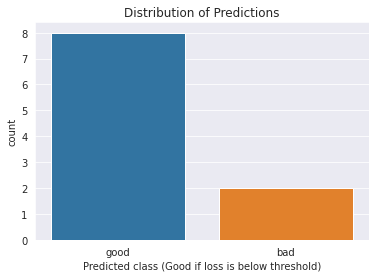

In [73]:
# plotting bad and good predictions
ax = sns.countplot(x="type1", data=bin_df)
ax.set_title("Distribution of Predictions")
ax.set_xlabel("Predicted class (Good if loss is below threshold)")

Text(0.5, 0, 'Predicted class (Good if loss is below threshold)')

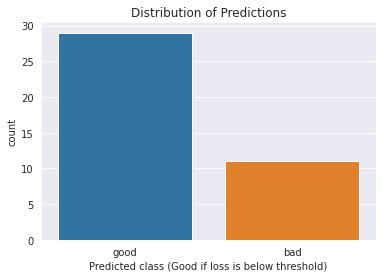

In [77]:
ax = sns.countplot(x="type1", data=bin_df1)
ax.set_title("Distribution of Predictions")
ax.set_xlabel("Predicted class (Good if loss is below threshold)")

#### Observation
The above two plotted distributions shows the distribution of good and bad predictions we got when we evaluated our best model for some data. In first distribution, we observe quite well number of good predictions around 80% given we chose around 10 samples of data. In second distribution, we tried to evaluate on more samples of data and found that model is still doing well with around 79% of good predictions.

In [162]:
bin_df1.head(3)

,actual_bird,pred1,loss,type_pred
0,plsvir,183,0.533597,good
1,amewoo,11,0.241052,good
2,casvir,65,0.949333,bad


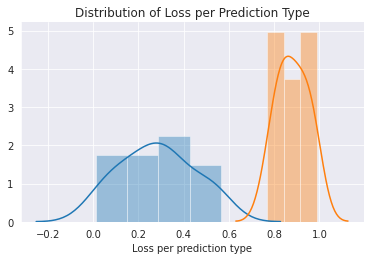

In [164]:
g = sns.FacetGrid(bin_df1, hue='type1',height=3.5,aspect=1.5)
g.map(sns.distplot, 'loss1')
plt.title("Distribution of Loss per Prediction Type")
plt.xlabel('Loss per prediction type')
plt.show()

#### Observation
The above dataframe shows the binning of our prediction into good and bad categories. While the plot above shows the distribution of loss for the good and bad predictions done by the model. Now that we have good and bad prediction let us analyze and try to find some patterns in the features of bad predictions.

In [141]:
def load_pred(bad_pred):
    """
    Return samples of the loaded file
    Argument: predicted label
    """
    d = data[10:40]
    file = d[d.ebird_code==bad_pred].filepath.iloc[0]
    y,s = librosa.load(file,sr=params.sr)
             
    return y,s


def plot(pred_bird):
    """
    plots mel-spec, waveplot and harmonics and perception of sound
    Argument: predicted label
    """
    # loading file
    y,_ = load_pred(pred_bird)
    y = y[:5*params.sr]
    
    # creating melspectrogram
    melspec = compute_melspec(y,params)
    plt.figure(figsize=(14,3))
    plt.subplot(131)
    librosa.display.specshow(melspec,x_axis='time', y_axis='mel')
    plt.title("mel-spec")
    
    # plotting waves of sound
    plt.subplot(132)
    librosa.display.waveplot(y)
    plt.title("waveplot of sound")
    
    # plotting harmonics and perception of sound
    y_harm_aldfly, y_perc_aldfly = librosa.effects.hpss(y)
    plt.subplot(133)
    plt.plot(y_perc_aldfly)
    plt.plot(y_harm_aldfly)
    plt.xlabel('Time')
    plt.legend(("perception", "harmonics"),loc='best')
    plt.title("harmonics-perpetual")
    
    plt.show()

In [86]:
# separating good and bad predictions labels
bad_pred = bin_df1[bin_df1['type_pred']=='bad'].actual_bird.values
good_pred = bin_df1[bin_df1['type_pred']=='good'].actual_bird.values

#### Analyzing Good Predictions

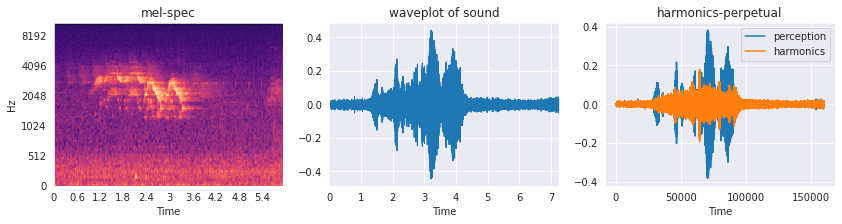

In [149]:
# plotting the features of good predicted one
plot(good_pred[7])

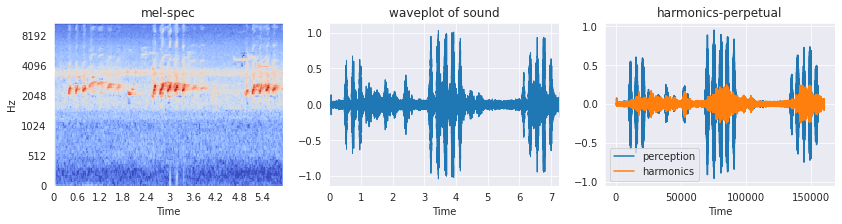

In [152]:
# plotting the features of good predicted one
plot(good_pred[5])

#### Observation
Before we go and analyze the features of bad predictions let us see the features of the good predictions and verify if the interpretation we have derived after model training and EDA is right or not. To understand the patterns in the features of the prediction, we analyzed features like mel-spectrogram, audio waveforms as we saw during our intial EDA section. The audio mel-spectrogram is a feature which represents the sound mel scaled frequency plotted against time axis.

In the above plotted images the left most shows the mel-spec images of the audio, middle is the waveplot while the right one shows percetual and harmonics of the sound.

From the all spec images plotted above, we see some highlighted portion in the image which suggests the call of the bird at that time, while the black indicates silence and other indicates noised and background sounds. The spikes in the plotted waveplots also indicates the presence of call of the bird at a time and silence in case of straight line. All the right most plots shows the presence of birdcalls along with distortion in the sound suggesting the presence of noise and background sounds.

* From all the mel-spec images we find that birdcall is present and in good quality as suggested by the presence of good and differentiable highlighted areas in the image.
* The wave plots plotted above also indicates that the presence of birdcalls in the audio is good with some silence as the call is not continuous or vary according to the bird species.
* The plots in right side indicates the presence of distortion in the audio i.e noise and background noises. The orange color is noises while blue one is the bird call we care for. From the plots we see that some noised are present but the calls are still distinguishable from the noise.
* As seen during training we have tried to introduce some gaussian noise ourselves as well as tried to supress the background noise to a limit while converting to the mel-spec features. So, we can say that the prediction as well as data is as we have expected to be while training and evaluation.

So, let us go and understand why the model is making those bad predictions.

#### Analyzing Bad Predictions

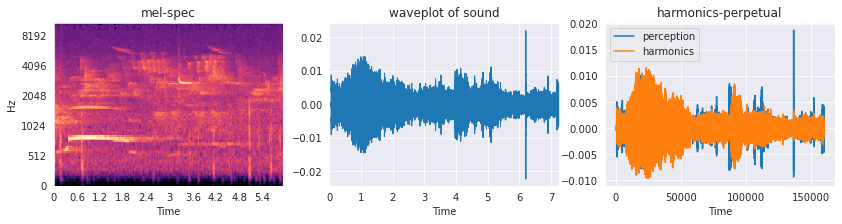

In [144]:
# plotting the features of bad predicted one
plot(bad_pred[2])

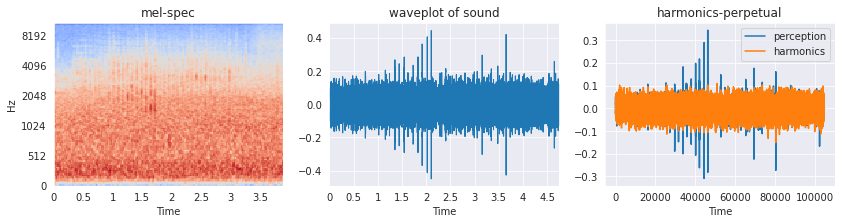

In [148]:
# plotting the features of bad predicted one
plot(bad_pred[6])

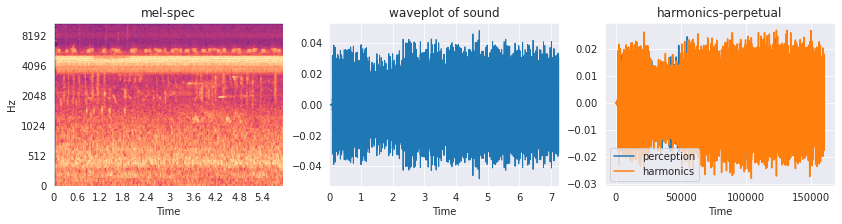

In [151]:
# plotting the features of bad predicted one
plot(bad_pred[8])

In [171]:
a,b = load_pred(bad_pred[6])
ipd.Audio(a,rate=b)

#### Observation
SImilar to the feature analysis of good prediction, we plotted three different features to properly undrrstand the patterns.
* From all the three mel-spec images plotted above we observe that unlike for good prediction features we cannot easily distinguish the highlighted sections as most of them is highlighted suggesting presence of either continuous bird calls or high noise and background sound or both.
* To furhter verfiy what we observed in spec images we come to the waveplots, in the wave plots plotted we see that we have quite up and downs in the plot but the amplitude at every time is does not quite fluctuates as what we have seen for good prediction features suggesting the presence of continuous high sound i.e either noise or continuous bird calls.
* Both these plots indicates that there might be contiuous birdcall as depending on the species or continuous noise present in the audio to give these kind of plot. But, we have also known that birds call cannot be continuous with this pitch and amplitude for a long time. So, there is a high chance of later possibility and to confirm that we plotted the third plot the right most ones.
* From the right most plots we can now clearly observe that we have high noise and background sound present in the audio file which is somewhat overlapping the bird call sound as you can observe from the orange color in the plot which mostly covers the bird's sound.
* We have also listened to the audio to verify the result as shown above.

We have found some interesting pattern in the features here. let us go ahead and see we can find something else.

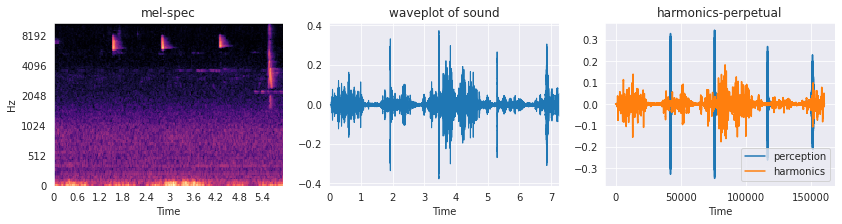

In [143]:
# plotting the features of bad predicted one
plot(bad_pred[1]) # baackground noise and less call

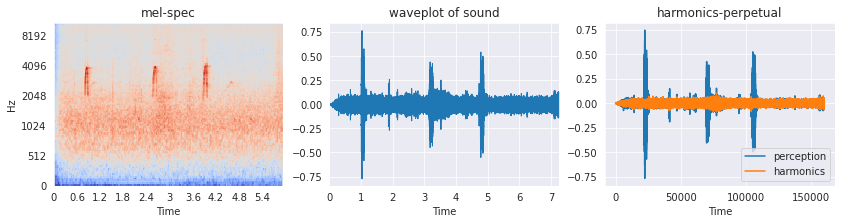

In [145]:
# plotting the features of bad predicted one
plot(bad_pred[3]) # background noise

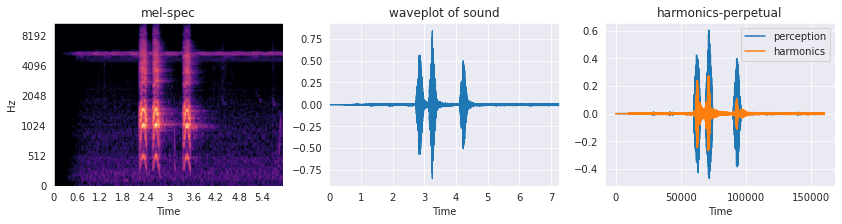

In [146]:
# plotting the features of bad predicted one
plot(bad_pred[4]) # Silence and very low bird call 

#### Observation
We observed the presence of excessive noise and other sounds in the audio in above examples. So, we decided to observe some more examples and see if we can find anything.
* Looking at the spec images `these above three cell's outputs`, we can say that we have spec images similar that of the good prediction ones, we can see distinguishable highlighted sections in the images then why it is a bad prediction? Maybe be beacause of presence of those extra black sections as in first and third images or the presence of those moderately highlighted sections in the second image. What could it be? 
* Also, the sections of the bird's call in the spec images is not sharp as we have seen in the good predictions features it may be because of the bird species call or low sound of the call in the recording. To verify these observations let us look at other plots.
* Looking at the middle plots i.e wave plots, the first wave plots suggests the presence of good bird call in the sound with quite varying amplitudes with time which does not answer our question so we looked at the first right most plot and see that yes we have quite good recording of the call but we also have that much noise and background noise.
* Looking at the second middle wave plot we observe the presence of noise and background sound but not in huge amount as seen in previous plots which is furhter verified by the harmonics and perceptual plot where we can clearly see the distortion.
* We found the reason now to be presence of the high signal to noise ratio than we expected i.e both the reason as we highlighted in first point.
* From the last wave plot we observe the presence of quite longer straight lines in the plot suggesting that the audio have quite long sequence of silence present. Looking at the perceptual and harmonics plot we can say that yes audio have quite longer silence present while the noise is reasonable as we might have expected.

### Summary of Bad Prediction Analysis
From the features analysis of bad predictions we have found some interesting patterns which is:-
1. The audio have higher Signal-to-Noise ratio(SNR) i.e either mostly noise, mostly background sounds, low calls, longer silence or more than one which caused this SNR to be high.

Then, comes the question did not we teach our model to handle these cases. Yes, we did to some extent as discussed in training part where we discussed augmentation of the features where we introduced noises ourselves, did filtered training based on SNR , pitch shifting for handle faster or lower audio, time and frequency shifting to handle silences etc. and we did well both on validation and here testing where we get the model evaluation score similar to our validation result. That means the models is doing good and as expected.

So, what can be done either we can process these audio before predicting or we can gather some more data like these and train the models again and evaluate we can do better. As, when we did introduced more backkground sounds and noise similar the above the predictions features i.e mostly overlapping and found that the model does not generalizes well and give even poorer results. So, we decided to go with trade off of predicting the right calls when the bird sound is good with reasonable noises and other sound than to make false predictions due to some of the outlier features.